# Reconhecimento de expressões matématicas escritas à mão

## Importa as bibliotecas necessárias

In [11]:
import sys
import os
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import pickle
import random
import one_hot
from preprocessamento import deskew, get_hog

## Constantes

In [2]:
ALTURA_MIN_DIGITO = 5
ALTURA_MAX_DIGITO = 90
LARGURA_MIN_DIGITO = 15
MARGEM_ERRO = 40
ANGULO_MAX_INLINE = 30

## Lê a imagem de teste

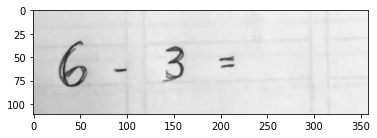

In [3]:
img = cv2.imread('7.jpeg',0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')

## Pré-processamento

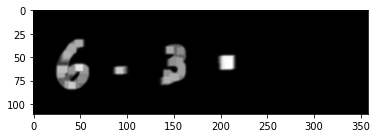

In [4]:
blurred = cv2.GaussianBlur(img, (7, 7), 0)
thresh = cv2.Canny(blurred, 20, 50)
thresh = cv2.GaussianBlur(thresh, (7, 7), 0)
erosion_size = 3
max_elem = 1
max_kernel_size = 21        
erosion_type = cv2.MORPH_RECT
element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
thresh = cv2.erode(thresh, element)
thresh = cv2.dilate(thresh, element)
plt.imshow(thresh, cmap = 'gray', interpolation = 'bicubic')


## Encontra todos os contornos na imagem e filtra para análise

[[93, 63], [206, 55], [150, 57], [41, 60]]


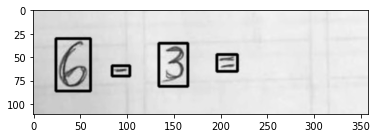

In [5]:
contours,hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
imgCopy = np.copy(img)
digitos = []
centros = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if h > ALTURA_MIN_DIGITO and h < ALTURA_MAX_DIGITO and w > LARGURA_MIN_DIGITO:
        digitos.append(cnt);
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centros.append([cX,cY])
        imgContornos = cv2.rectangle(imgCopy,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(imgContornos, cmap = 'gray', interpolation = 'bicubic')
print(centros)

## Apresenta as imagens dos contornos filtrados

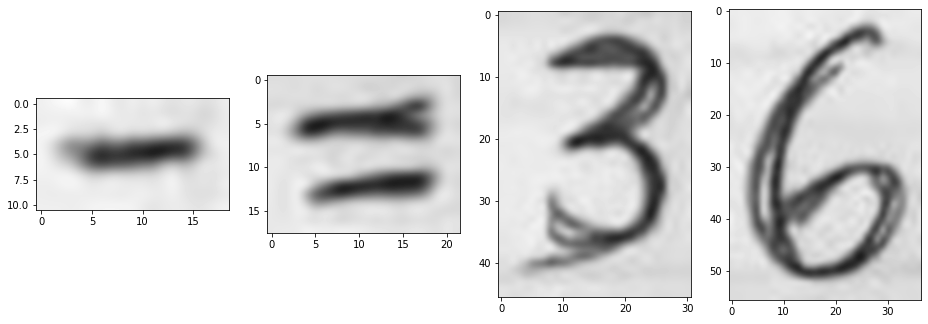

In [6]:
plt.figure(figsize=(20,10))
columns = 5
for i,cnt in enumerate(digitos):
    x,y,w,h = cv2.boundingRect(cnt)
    cropped = img[y:y+h , x:x+w]
    plt.subplot(len(digitos) / columns + 1, columns, i + 1)
    plt.imshow(cropped, cmap = 'gray', interpolation = 'bicubic')

## Identifica o primeiro dígito

[84, 196, 134, 24]
[59, 47, 35, 30]
3
3


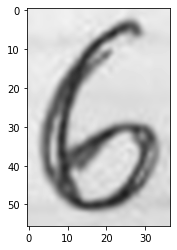

In [7]:
X = []
Y = []
for cnt in digitos:
    x,y,w,h = cv2.boundingRect(cnt)
    X.append(x)
    Y.append(y)
print(X)
print(Y)
Ymedia = np.mean(Y)
while np.all(Y):
    indexMin = np.where(X == np.min(X))
    print(indexMin[0][0])
    if Y[indexMin[0][0]] < (Ymedia - MARGEM_ERRO):
        Y = np.delete(Y,indexMin[0][0])
        X = np.delete(X,indexMin[0][0])
        print(Y)
    else:
        break
index = indexMin[0][0]
print(index)
x,y,w,h = cv2.boundingRect(digitos[index])
cropped = img[y:y+h , x:x+w]
plt.imshow(cropped, cmap = 'gray', interpolation = 'bicubic')


## Calcula os ângulos entre o centro do primeiro dígito e os centros dos outros dígitos

[3, 1, 1, 0]


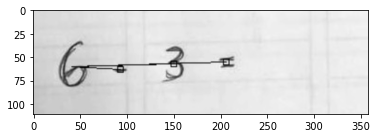

In [8]:
angulos = []
imgCopy3 = np.copy(img)
for i, centro in enumerate(centros):
    if i != index:
        vetor1 = [centro[0] - centros[index][0], centro[1] - centros[index][1]]
        vetor2 = [1,0]
        length1 = math.sqrt(vetor1[0] * vetor1[0] + vetor1[1] * vetor1[1])
        length2 = math.sqrt(vetor2[0] * vetor2[0] + vetor2[1] * vetor2[1])
        angulos.append(math.floor(math.degrees(math.acos((vetor1[0] * vetor2[0] + vetor1[1] * vetor2[1])/ (length1 * length2)))))
        cv2.line(imgCopy3,(centros[index][0],centros[index][1]),(centro[0],centro[1]),0,1)
        cv2.rectangle(imgCopy3,(centro[0]-3,centro[1]-3),(centro[0]+3,centro[1]+3),(0,255,0),1)
    else:
        angulos.append(0)
print(angulos)
plt.imshow(imgCopy3, cmap = 'gray', interpolation = 'bicubic')


## Identifica a sequência de caracteres na mesma linha

In [9]:
print(centros)
centrosInline = []
for i,angulo in enumerate(angulos):
    if angulo > ANGULO_MAX_INLINE:
        print("Contorno descartado pelo critério de ângulo máximo")
    else:
        centrosInline.append([centros[i],i])
a = sorted(centrosInline, key=lambda a_entry: a_entry[0]) 
print(a)

[[93, 63], [206, 55], [150, 57], [41, 60]]
[[[41, 60], 3], [[93, 63], 0], [[150, 57], 2], [[206, 55], 1]]


## Classificador

### Manipulação dos dados

In [12]:
outputs_rel_path = 'data'
train_dir = os.path.join(outputs_rel_path, 'train')
test_dir = os.path.join(outputs_rel_path, 'test')

with open(os.path.join(train_dir, 'train.pickle'), 'rb') as train:
    train_set = pickle.load(train)
with open(os.path.join(test_dir, 'test.pickle'), 'rb') as test:
    test_set = pickle.load(test)

print('Deskew imagens... ')
digits_deskewed = []
for train in train_set:
    digits_deskewed.append(deskew(train['features'],50))

print('Definindo os parametros para o descritor HOG ...')
# HoG
hog = get_hog();

print('Calculando o descritor HOG de cada digito... ')
hog_descriptors = []
for img in digits_deskewed:
    hog_descriptors.append(hog.compute(img))
hog_descriptors = np.squeeze(hog_descriptors)

Deskew imagens... 
Definindo os parametros para o descritor HOG ...
Calculando o descritor HOG de cada digito... 


error: OpenCV(4.1.0) /io/opencv/modules/objdetect/src/hog.cpp:244: error: (-215:Assertion failed) img.type() == CV_8U || img.type() == CV_8UC3 in function 'computeGradient'


### Visualiza os dados

In [ ]:
box_size = 50
n_samples = 40
n_cols = 8

# Load classes
classes = open('classes.txt', 'r').read().split()

'Compute number of rows with respect to number of both columns and samples provided by user'
rows_numb = math.ceil(n_samples / n_cols)

'Instanciate a figure to plot samples on'
figure, axis_arr = plt.subplots(rows_numb, n_cols, figsize=(12, 4))
figure.patch.set_facecolor((0.91, 0.91, 0.91))

sample_id = 0
for row in range(rows_numb):
    for col in range(n_cols):

        if sample_id < n_samples:
            'Generate random sample id'
            random_id = random.randint(0, len(test_set))
            training_sample = test_set[random_id]
            # Decode from one-hot format to string
            label = one_hot.decode(training_sample['label'], classes)

            axis_arr[row, col].imshow(training_sample['features'].reshape((box_size, box_size)), cmap='gray')
            axis_arr[row, col].set_title('Classe: \"' + label + '\"', size=13, y=1.2)

        'Remove explicit axises'
        axis_arr[row, col].axis('off')

        sample_id += 1

'Adjust spacing between subplots and window border'
figure.subplots_adjust(hspace=1.4, wspace=0.2)
plt.savefig('visualization.png')

# Brings foreground
plt.show()

### Configuração

In [ ]:
C=12.5
gamma=0.50625
model = cv2.ml.SVM_create()
model.setGamma(gamma)
model.setC(C)
model.setKernel(cv2.ml.SVM_RBF)
model.setType(cv2.ml.SVM_C_SVC)


### Treino

In [ ]:
model.train(train_set[:]['features'], cv2.ml.ROW_SAMPLE, train_set[:]['label'])

### Avaliação

In [ ]:

predictions = model.predict(samples)[1].ravel()
accuracy = (labels == predictions).mean()
print('Acuracia do classificador: %.2f %%' % (accuracy*100))

confusion = np.zeros((10, 10), np.int32)
for i, j in zip(labels, predictions):
    confusion[int(i), int(j)] += 1
print('Matriz confusao:')
print(confusion)